In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

lm_path = f"../language_modeling.csv"
mcp_path = f"../multiple_choice_prompt.csv"
poe_path = f"../process_of_elimination.csv"
cha_path = f"../channel.csv"
cal_path = f"../calibration.csv"
lm_df = pd.read_csv(lm_path)
mcp_df = pd.read_csv(mcp_path)
poe_df = pd.read_csv(poe_path)
cha_df = pd.read_csv(cha_path)
cal_df = pd.read_csv(cal_path)

poe_df = poe_df[poe_df["mask_strategy"] == "below_average"] # "below_average" "lowest"


In [2]:
# drop columns should be a list. Use type hints to enforce this.
def process(df, drop_columns=None):
    # get rid of identical rows 
    df = df.drop_duplicates() # is this really necessary?
    # df = df[df["checkpoint"].str.startswith("google/flan-t5")]
    # remove the seed column and batch_size column
    if isinstance(drop_columns, list):
        drop_columns += ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    else:
        drop_columns = ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    df = df.drop(columns=drop_columns)
    # shorten checkpoint names
    df['checkpoint'] = df["checkpoint"].apply(lambda x: x.split("/")[-1])
    return df
    

In [3]:
lm_df = process(lm_df)
mcp_df = process(mcp_df)
poe_df = process(poe_df, drop_columns=["prompting_method", "scoring_method", "mask_accuracy", "mask_strategy"])
cha_df = process(cha_df)
cal_df = process(cal_df)
# cd_df = process(cd_df, ) # drop_columns=["expert_method", "amateur_method", "expert_accuracy", "amateur_accuracy"]
# concatenate all dataframes
pre_df = pd.concat([lm_df, mcp_df, poe_df, cha_df, cal_df, ]) # cd_df

pre_df = pre_df.drop(columns=["mask_token"])

n_shot = 0 # 4.0, 0
df = pre_df[pre_df["n_shot"] == n_shot]

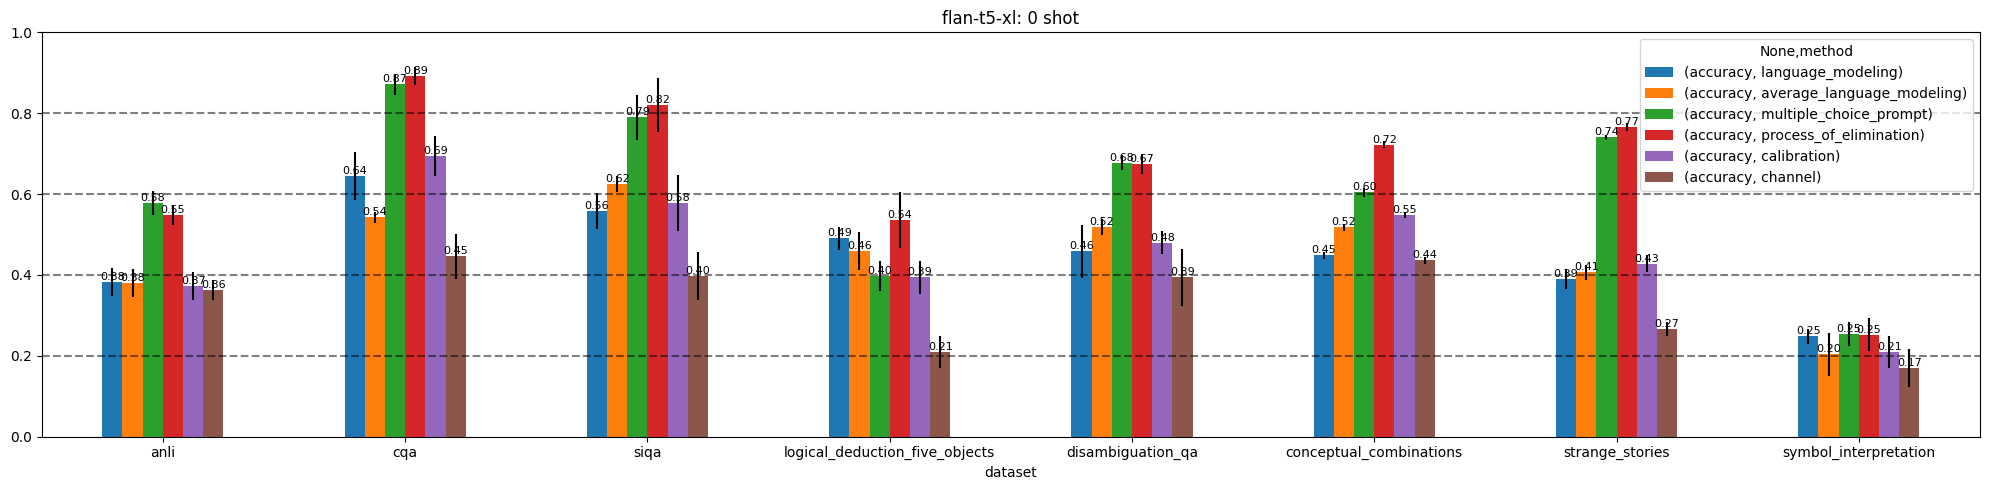

In [27]:
datasets="anli cqa siqa logical_deduction_five_objects disambiguation_qa conceptual_combinations strange_stories symbol_interpretation".split()
method_index = [('accuracy', 'language_modeling'), ('accuracy', 'average_language_modeling'), ('accuracy',    'multiple_choice_prompt'), ('accuracy',    'process_of_elimination')]
method_index += [('accuracy', 'calibration'), ('accuracy', 'channel')] 
# plot flan-t5-xl on all benchmarks.
model = "flan-t5-xl"
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_ylim([0.0, 1.0])
h_lines = [0.2, 0.4, 0.6, 0.8]

sing_df = df[(df["dataset"].isin(datasets)) & (df["checkpoint"] == model)]

# sing_df.to_csv("main_exp.csv")

sing_df = sing_df.drop(columns=["checkpoint"])

sing_df = sing_df.groupby(["dataset","method"])
sing_means = sing_df.mean().unstack().reindex(method_index, axis="columns").reindex(datasets, axis="rows")
sing_errors = sing_df.std().unstack().reindex(method_index, axis="columns").reindex(datasets, axis="rows")
sing_means.plot.bar(yerr=sing_errors, rot=0, figsize=(20, 5), title=f"{model}: {n_shot} shot", legend=True, ax=ax)
# plot numbers on top of bars
for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f' % float(p.get_height()), ha='center', va='bottom', fontsize=8)
for line in h_lines:
    ax.axhline(line, color="black", linestyle="--", alpha=0.5)

plt.tight_layout()
# plt.savefig("main_exp.png", dpi=300, bbox_inches='tight')

In [28]:
# to produce latex table.

# post processing in latex: repalce table with table*
# add \hline

# change format, and concatenate two strings.


sing_all = sing_means.applymap(lambda x: f"{x*100:.1f}") + sing_errors.applymap(lambda x: f"\\textsubscript{{{x*100:.1f}}}")



method_index = [('accuracy', 'language_modeling'), 
                ('accuracy', 'average_language_modeling'), 
                ('accuracy', 'calibration'),
                ('accuracy', 'channel'),
                ('accuracy',    'multiple_choice_prompt'), 
                ('accuracy',    'process_of_elimination'),]
sing_all = sing_all.reindex(method_index, axis="columns")
sing_all = sing_all.rename_axis("Task")
sing_all.columns = sing_all.columns.set_names([None, "Method"])

latex_means = sing_all.rename(columns={"language_modeling": "LM",
                                         "average_language_modeling": "AVG",
                                         "multiple_choice_prompt": "MCP",
                                         "process_of_elimination": "PoE",
                                         "calibration": "Calibration",
                                         "channel": "Channel",},
                                index={"anli":"ANLI",
                                        "cqa": "CQA",
                                        "siqa": "SIQA",
                                       "logical_deduction_five_objects": "LD",
                                        "disambiguation_qa": "DQA",
                                        "conceptual_combinations": "CC",
                                        "strange_stories": "SS",
                                        "symbol_interpretation": "SIT",
                                       })
latex_means = latex_means.rename(index={"logical deduction five objects": "logical deduction"}, 
                                 columns={"process of elimination": "process of elimination (PoE)"})

# drop "accuarcy" to save some space
latex_means = latex_means.droplevel(0, axis=1)
# add \hline
# latex_means = latex_means.applymap(lambda x: x + " \\\\ \\hline")

latex_means.style.to_latex(
    buf="main_exp.tex",
    column_format="l|c|c|c|c|c|c",
    position="h",
    position_float="centering",
    label="tab:main_exp",
    caption=r"Accuracy scores (with standard deviation) on 8 tasks. Best scores are \textbf{bold}, and second-best scores are \underline{underlined}. LM refers to language modeling, AVG refers to average language modeling, MCP refers to multiple choice prompting. Our method (PoE) achieves the best or comparable performance on all tasks.",
    multicol_align="c",
    multirow_align="c",
)

In [29]:
sing_means

accuracy                            \
method                         language_modeling average_language_modeling   
dataset                                                                      
anli                                       0.382                     0.380   
cqa                                        0.644                     0.542   
siqa                                       0.558                     0.624   
logical_deduction_five_objects             0.490                     0.460   
disambiguation_qa                          0.458                     0.518   
conceptual_combinations                    0.448                     0.518   
strange_stories                            0.390                     0.406   
symbol_interpretation                      0.248                     0.204   

                                                                              \
method                         multiple_choice_prompt process_of_elimination   
dataset                                                                        
anli                                            0.578                  0.548   
cqa                                             0.872                  0.892   
siqa                                            0.790                  0.820   
logical_deduction_five_objects                  0.398                  0.536   
disambiguation_qa                               0.678                  0.674   
conceptual_combinations                         0.604                  0.722   
strange_stories                                 0.740                  0.766   
symbol_interpretation                           0.254                  0.252   

                                                    
method                         calibration channel  
dataset                                             
anli                                 0.372   0.362  
cqa                                  0.694   0.446  
siqa                                 0.578   0.398  
logical_deduction_five_objects       0.394   0.210  
disambiguation_qa                    0.480   0.394  
conceptual_combinations              0.548   0.436  
strange_stories                      0.428   0.266  
symbol_interpretation                0.210   0.170

In [30]:
# largest value
# sing_means.max(axis=1)*100
# second largest value
sing_means.apply(lambda row: row.nlargest(2).iloc[-1], axis=1) * 100

dataset
anli                              54.8
cqa                               87.2
siqa                              79.0
logical_deduction_five_objects    49.0
disambiguation_qa                 67.4
conceptual_combinations           60.4
strange_stories                   74.0
symbol_interpretation             25.2
dtype: float64